In [ ]:
!pip install d2l

困惑度 1.0, 116244.6 标记/秒 cuda:0
t i m e   t r a v e l l e r   w i t h   a   s l i g h t   a c c e s s i o n   o f c h e e r f u l n e s s   r e a l l y   t h i
t r a v e l l e r y o u   c a n   s h o w   b l a c k   i s   w h i t e   b y   a r g u m e n t   s a i d   f i l b y
h i s   h a n d   d i n e   w i r i   a y   n o   m a l o u n t   s   i v i t y   i r   w a t   a t   y e f   o n  


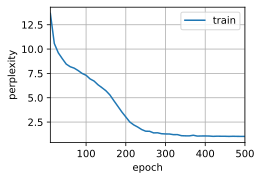

In [8]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=False)

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))     # 28 * 512
    W_hh = normal((num_hiddens, num_hiddens)) # 512 * 512
    b_h = torch.zeros(num_hiddens, device=device)   # 512
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))  # 512 * 28
    b_q = torch.zeros(num_outputs, device=device) # 28
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):   # batch_size的该方法的局部变量，全局变量也有batch_size，
# 当局部变量和全局变量共存的时候，局部变量生效。从RNN的理论上讲，该值可以被初始化为1或者batch_size = 32都可，或者是输入train_iter中得到的原始X.shape[0]状态
    return torch.zeros((batch_size, num_hiddens), device=device)

def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`, `批量大小`, `词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    for X in inputs:  # 32 * 28，循环35次
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q 
        outputs.append(Y)
    return torch.cat(outputs, dim=0), H


class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        

    def __call__(self, X, state):  # 因为这个模型没有继承自nn.Module模块，因此只能通过实现__call__函数来做forward
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  # 得到输入的one-hot encoding
        return self.forward_fn(X, state, self.params)  # 回调函数

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

# 定义model
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)

# LSTM提出的clipping：梯度裁剪技术
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = 0.0
    results = 0.0
    for p in params:
      results += torch.sum(p.grad**2)
    norm = torch.sqrt(results)
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 不失一般性，假设prefix='travller'
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)  # 1 * 512维度的tensor
    outputs = [vocab[prefix[0]]]
    # get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    def get_input():
      return torch.tensor([outputs[-1]], device=device).reshape((1,1))

    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 标记数量
    for X, Y in train_iter:  # 取出的X和Y的维度还是32 * 35
        if state is None: # or use_random_iter:   # state [32, 512]
            # 在第一次迭代`state`
            state = net.begin_state(batch_size=1, device=device)   # 初始化其实隐藏状态H0
        else:
          state.detach_()   # 不跟踪state的梯度信息
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state) # __call_  X的维度32 * 35 变成 35 * 32 * 28
        # print("y_hat_shape:", y_hat.shape)   # 1120*28的one-hot向量
        # print("y_shape:", y.shape)  # 1120 长度的一维向量
        l = loss(y_hat, y).mean() # 使用nn.CrossEntropyLoss(input, target)，其中input可以是one-hot encodding，但是target只能说数值类型，不能是one-hot encodding
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    def updater(batch_size):
      return d2l.sgd(net.params, lr, batch_size)
    # updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    def predict(prefix):
      return predict_ch8(prefix, 50, net, vocab, device)
    # predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 初始化
    if isinstance(net, nn.Module): 
        updater = torch.optim.Adam(net.parameters(), lr) 
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter = True)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
    print(predict("his hand"))

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [ ]:
import collections
import re
from d2l import torch as d2l

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): 
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    print(lines)
    results = []
    for line in lines:
      results.append(re.sub('[^A-Za-z]+', ' ', line).strip().lower())
    return results

lines = read_time_machine()
# print(f'# text lines: {len(lines)}')
# print(lines[0])
def tokenize(lines, token='word'):
    results = []
    if token == 'word':
        for line in lines:
          arr = line.split()
          results.append(arr)
        return results
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)  # 二维list，list[i]都表示原来文本的一行
# tokens = tokenize(lines, 'char')  # 测试结果
# print(tokens)
# for i in range(11):
#     print(tokens[i])

class Vocab:  # 词汇表的目的就是生成一个hash table，每一个token都应该对应一个唯一的索引值 [token, index]
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        counter = count_corpus(tokens)
        # print(type(counter))
        # for key, value in counter.items():
        #   print(key, value)   # 打印counter.items()字典中的每个元素
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)   # 默认是升序，reverse=True为降序
        # print(type(self.token_freqs))  # 返回一个list对象
        # print(self.token_freqs)

        self.unk = 0
        self.idx_to_token = ['unk']
        self.token_to_idx =  dict()  # idx_to_token 为list类型 token_to_idx为dict类型
        self.token_to_idx['unk'] = 0
        for token, _ in self.token_freqs:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.token_to_idx)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple, dict)):
            return self.token_to_idx.get(tokens, self.unk)   # 访问token_to_idx字典，如果key在字典中，则返回其对应的value，如果key不在，则返回self.unk标记
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple,dict)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    # 这里的 `tokens` 是 1D 列表或 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):   # isinstance 就是判断tokens[0]是不是list类型
        # 将标记列表展平成使用标记填充的一个列表
        results = []
        for line in tokens:
          for t in line:
            results.append(t)
        tokens = results
    return collections.Counter(tokens)

vocab =Vocab(tokens)
# for i in [0, 10]:
#     print('words:', tokens[i])
#     print('indices:', vocab[tokens[i]])  # 这里默认调用__getitem__方法

def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的标记索引列表和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')  # 二维数组
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每一个文本行，不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    # corpus = [vocab[token] for line in tokens for token in line]  # 把整个文本表示为一个一维index list
    corpus = []
    for line in tokens:
      for token in line:
        corpus.append(vocab[token])
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
print(corpus)
len(corpus), len(vocab)

In [52]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行连接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

len(corpus), len(corpus[:-1]), len(corpus[1:])

bigram_tokens = []
for pair in zip(corpus[:-1], corpus[1:]):
  bigram_tokens.append(pair)
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

# def seq_data_iter_sequential(corpus, batch_size, num_steps):
#   offset = random.randint(0, num_steps)
#   num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
#   Xs = torch.tensor(corpus[offset:offset+num_tokens])
#   Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])

#   Xs = Xs.reshape(batch_size, -1)
#   Ys = Ys.reshape(batch_size, -1)
#   num_batches  = Xs.shape[1]//num_steps

#   for i in range(0, num_steps*num_batches, num_steps):
#     X = Xs[:,i: i+num_steps]
#     Y = Ys[:, i: i+num_steps]
#     yield X, Y

def seq_data_iter_random(corpus, batch_size, num_steps):
  offset = random.randint(0, num_steps-1)
  corpus = corpus[offset:]

  num_subseqs = (len(corpus) - 1) // num_steps

  indices = list(range(0, num_subseqs * num_steps, num_steps))
  random.shuffle(indices)
  num_batches = num_subseqs // batch_size
  def data(j):
    return corpus[j:j+num_steps]
  for i in range (0, num_batches * batch_size, batch_size):
    indices_per = indices[i:i+batch_size]
    X = [data(j) for j in indices_per]
    Y = [data(j+1) for j in indices_per]
    yield torch.tensor(X), torch.tensor(Y)
my_seq = list(range(35))
print(my_seq)
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
X:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])
X:  tensor([[11, 12, 13, 14, 15],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [27, 28, 29, 30, 31]])
X:  tensor([[16, 17, 18, 19, 20],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6]])
